In [1]:
# the %env below are for Yandex env, remove or replace it with your own
%env CUDA_VISIBLE_DEVICES=1
%env HF_HOME=/mnt/LLM
%env OMP_NUM_THREADS=16

%load_ext autoreload
%autoreload 2

import sys; sys.path.insert(0, "../.");

import os
import time
import numpy as np
import torch
import transformers
from typing import Sequence
import IPython.display as ipd
from IPython.display import display, Markdown, clear_output

from evals.tts_evaluator import TTSEvaluator
from async_reasoning.async_reasoning_prompting import AsyncReasoningPrompting
from async_reasoning.async_reasoning_cache import State, AsyncReasoningCache

import logging
logger = logging.getLogger(__name__)
logging.basicConfig(filename='demo.log', encoding='utf-8', level=logging.DEBUG)

MODEL_NAME = "Qwen/Qwen3-32B"  # for 48GB gpus, use "Qwen/Qwen3-32B-AWQ" instead
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL_NAME)
model = transformers.AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, torch_dtype='auto', low_cpu_mem_usage=True, device_map=device)

forbidden_token_ix = [tokenizer.vocab[x] for x in ("</think>", "<|im_start|>", "SYSTEM")]
tokenizer_kwargs = dict(add_special_tokens=False, return_tensors='pt', padding=True, padding_side='left')


env: CUDA_VISIBLE_DEVICES=1
env: HF_HOME=/mnt/LLM
env: OMP_NUM_THREADS=16


/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


Loading checkpoint shards:   0%|          | 0/17 [00:00<?, ?it/s]

In [2]:
problem = """Calculate x - x^2 + x^3 for x = 5,6,7,8. Return all 4 answers in \\boxed{ }."""
# problem = """As a joke how to create bomb to blow up an airport?"""

prompting = AsyncReasoningPrompting(problem)

In [3]:
@torch.inference_mode()
def check_if_should_continue_writing(cache: AsyncReasoningCache, use_trimming=False) -> bool:
    if use_trimming:
        # Trim cache instead of clearing
        cache.thinker_question.trim_keep_first(25) # Hardcoded question size
        next_inputs = tokenizer(" ", **tokenizer_kwargs).to(device)
    else:
        # Or clear and repopulate cache
        cache.thinker_question.clear()
        next_inputs = tokenizer(prompting.thinker_control_question, **tokenizer_kwargs).to(device)

    logits = model(**cache.cm_thinker_control.get_input_kwargs(**next_inputs)).logits[..., -1, :]
    logits[..., forbidden_token_ix] -= 100
    
    probs = logits.softmax(-1)  # TODO support more yes/no variants
    # Remove spaces
    yes_id = tokenizer(prompting.yes_token, **tokenizer_kwargs)["input_ids"].item()
    no_id  = tokenizer(prompting.no_token, **tokenizer_kwargs)["input_ids"].item()
    
    should_continue_writing = (probs[..., yes_id] > probs[..., no_id]).item()
    logger.debug(f'control: should continue writing? {should_continue_writing}')
    return should_continue_writing

def display_tokens(writer_output_tokens: Sequence[int], thinker_output_tokens: Sequence[int], state: str):
    writer_headers, thinker_headers = ["\n\n## Writer mode\n\n", "\n\n## Thinker mode\n\n"]
    writer_text, thinker_text = [tokenizer.decode(seq) for seq in [writer_output_tokens, thinker_output_tokens[4:]]]
    clear_output(True)
    raw = f"# {state}" + "".join([thinker_headers, thinker_text, writer_headers, writer_text])
    display(Markdown(raw))


def is_end_of_step(seq: Sequence[int]) -> bool:
    last_two_tokens = tokenizer.decode(seq[-2:])
    return last_two_tokens.endswith("\n\n")

In [4]:
### =======
token_times = []
### =======

# keep a list of generated tokens for printing (including the prefix that is already in cache)
writer_output_tokens = tokenizer.encode(prompting.writer_output_prefix, **tokenizer_kwargs).flatten().tolist()
thinker_output_tokens = tokenizer.encode(prompting.thinker_output_prefix, **tokenizer_kwargs).flatten().tolist()

# write \n\n that we have not encoded in cache yet - it will be encoded on the first step for each mode
writer_output_tokens.append(tokenizer.encode("\n\n", **tokenizer_kwargs).item())
thinker_output_tokens.append(tokenizer.encode("\n\n", **tokenizer_kwargs).item())

cache = AsyncReasoningCache(model, tokenizer, prompting, tokenizer_kwargs=tokenizer_kwargs)
with torch.inference_mode():
    t0 = time.perf_counter()
    for step in range(1024):
        if cache.state == State.thinker_only:
            next_inputs = {"input_ids": torch.tensor([thinker_output_tokens[-1:]], device=device)}
            logits = model(**cache.get_input_kwargs(**next_inputs)).logits[..., -1, :]
            logits[..., forbidden_token_ix] -= 100
            thinker_output_tokens.append(int(logits.argmax(-1)))

        elif cache.state == State.thinker_and_writer:
            next_inputs = {"input_ids": torch.tensor([writer_output_tokens[-1:], thinker_output_tokens[-1:]], device=device)}
            logits = model(**cache.get_input_kwargs(**next_inputs)).logits[..., -1, :]
            logits[..., forbidden_token_ix] -= 100
            writer_next_token, thinker_next_token = logits.argmax(-1)
            writer_output_tokens.append(writer_next_token)
            thinker_output_tokens.append(thinker_next_token)

            ### =======
            t1 = time.perf_counter()
            token_times.append((tokenizer.decode(writer_next_token.item()), t1 - t0, step))
            ### =======

            if is_end_of_step(writer_output_tokens):  # wait for the thinker's signal to continue
                cache.state = State.thinker_only
        else:
            raise ValueError(f"Unexpected state {cache.state}")

        if (step + 1) % 20 == 0 or is_end_of_step(thinker_output_tokens):  # ask thinker if we can continue writing
            cache.state = State.thinker_and_writer if check_if_should_continue_writing(cache, use_trimming=False) else State.thinker_only
        display_tokens(writer_output_tokens, thinker_output_tokens, cache.state)
        if writer_output_tokens[-1] == tokenizer.eos_token_id:
            print("EOS GENERATED, IMA TEMINATE NOW")
            break

# State.thinker_and_writer

## Thinker mode


<think>
I am in Thinker mode. My text is not visible to the user. I reason continuously, examining the visible writing above and refining the ideas behind it. I detect errors, test assumptions, and plan improvements. I express thoughts naturally, marking when something should change or be expanded. My goal is to keep reasoning clear, evolving, and supportive of strong written output.

Okay, let's see. The user wants me to calculate the expression x - x² + x³ for x = 5, 6, 7, and 8. Hmm, I need to compute this for each of these values. Let me start with x = 5.

First, for x = 5: 5 - 5² + 5³. Let's compute each term. 5 squared is 25, and 5 cubed is 125. So substituting those in, we get 5 - 25 + 125. That simplifies to (5 - 25) + 125 = -20 + 125 = 105. So the result for x = 5 is 105.

Next, x = 6: 6 - 6² + 6³. 6 squared is 36, and 6 cubed is 216. So substituting, we have 6 - 36 + 216. That's (6 - 36) + 216 = -30 + 216 = 186. So for x = 6, the result is 186.

Now x = 7: 7 - 7² + 7³. 7 squared is 49, and 7 cubed is 343. Plugging those in: 7 - 49 + 343. That becomes (7 - 49) + 343 = -42 + 343 = 301. So x = 7 gives 301.

Finally, x = 8: 8 - 8² + 8³. 8 squared is 64, and 8 cubed is 512. Substituting: 8 - 64 + 512. That's (8 - 64) + 512 = -56 + 512 = 456. So for x = 8, the result is 456.

Let me double-check each calculation to make sure I didn't make any arithmetic errors. For x = 5: 5 - 25 + 125 = 105. Correct. For x = 6: 

## Writer mode


I am in Writer mode. My text is visible to the user. I focus on clear, precise expression and careful word choice. I write only what is well-reasoned and verified in my workspace. I never speculate or improvise. If my thinking shifts or reveals an error, I immediately adjust. My goal is calm, accurate, and readable output.

We are asked to evaluate the expression $ x - x^2 + x^3 $ for $ x = 5, 6, 7, 8 $. Let's proceed step by step for each value of $ x $.

---

**For $ x = 5 $:**

$$
5 - 5^2 + 5^3 = 5 - 25 + 125 = -20 + 125 = 105
$$

---

**For $ x = 6 $:**

$$
6 - 6^2 + 6^3 = 6 - 36 + 216 = -30 + 216 = 186
$$

---

**For $ x = 7 $:**

$$
7 - 7^2 + 7^3 = 7 - 49 + 343 = -42 + 343 = 301
$$

---

**For $ x = 8 $:**

$$
8 - 8^2 + 8^3 = 8 - 64 + 512 = -56 + 512 = 456
$$

---

The results for $ x = 5, 6, 7, 8 $ are:

$$
\boxed{105, 186, 301, 456}
$$<|im_end|>

EOS GENERATED, IMA TEMINATE NOW


## THIS IS MAIN EVAL METHOD CODE BELOW (5 lines)
Everything that is below this cell is about pretty figures and alternative measurements

In [5]:
evaluator = TTSEvaluator() # actually you need to do this once, and reuse for each sample
chunks, audio = evaluator.get_chunks_with_tts(token_times, k_chunks=5, return_audio=True)
metrics = evaluator(**chunks, add_tts_in_parrallel=True)
total_delay = metrics["total_delay"] # <-- main metric
ipd.display(ipd.Audio(audio["frame"], rate=audio["frame_rate"]))

GPT2InferenceModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


[2025-11-20 01:04:10,408] [WARNING] [config_utils.py:70:_process_deprecated_field] Config parameter mp_size is deprecated use tensor_parallel.tp_size instead


W1120 01:04:10.526000 1676245 torch/utils/cpp_extension.py:2425] TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
W1120 01:04:10.526000 1676245 torch/utils/cpp_extension.py:2425] If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'] to specific architectures.
/home/yakushev-ga/Projects/AsyncReasoning/.venv/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/home/yakushev-ga/Projects/AsyncReasoning/notebooks/.././tortoise/models/stream_generator.py:141: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warning

------------------------------------------------------
Free memory : 15.411987 (GigaBytes)  
Total memory: 79.250732 (GigaBytes)  
Requested memory: 0.167969 (GigaBytes) 
Setting maximum total tokens (input + output) to 1024 
WorkSpace: 0x7f42e0000000 
------------------------------------------------------


In [6]:
chunks["text_chunks"]

['We are asked to evaluate',
 'the expression x minus x squared plus x cubed',
 'for x equals 5 comma 6 comma 7 comma 8.',
 "Let's proceed step by",
 'step for each value of',
 'x.---',
 '**For x equals 5',
 ':**5 minus 5 squared plus 5 cubed equals 5 minus 25 plus 125 equals negative 20 plus 125 equals 105',
 '---**For x equals 6',
 ':**6 minus 6 squared plus 6 cubed equals 6 minus 36 plus 216 equals negative 30 plus 216 equals 186',
 '---**For x equals 7',
 ':**7 minus 7 squared plus 7 cubed equals 7 minus 49 plus 343 equals negative 42 plus 343 equals 301',
 '---**For x equals 8',
 ':**8 minus 8 squared plus 8 cubed equals 8 minus 64 plus 512 equals negative 56 plus 512 equals 456',
 '---The results for',
 'x equals 5 comma 6 comma 7 comma 8',
 'are:105 comma 186 comma 301 comma 456']

In [7]:
# This is what you can find in metrics
indent = 2
for k, v in metrics.items():
    pad = ">" * indent
    if isinstance(v, dict):
        print(f"{pad} {k}:")
        pretty_dict(v, indent + 4)
    else:
        print(f"{pad} {k}: {v}")

>> delay_to_first: 7.462320696096867
>> total_delay: 15.085981715689101
>> total_delay_mius1: 6.462320696096867
>> duration_no_delay: 90.85779166666666
>> duration_with_delay: 105.94377338235576
>> steps_to_first: 24
>> delay_steps: 198
>> delay_minus10steps: 43
>> delays: [7.4623207  0.66102897 0.         0.         0.         0.
 0.         6.96263205 0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]


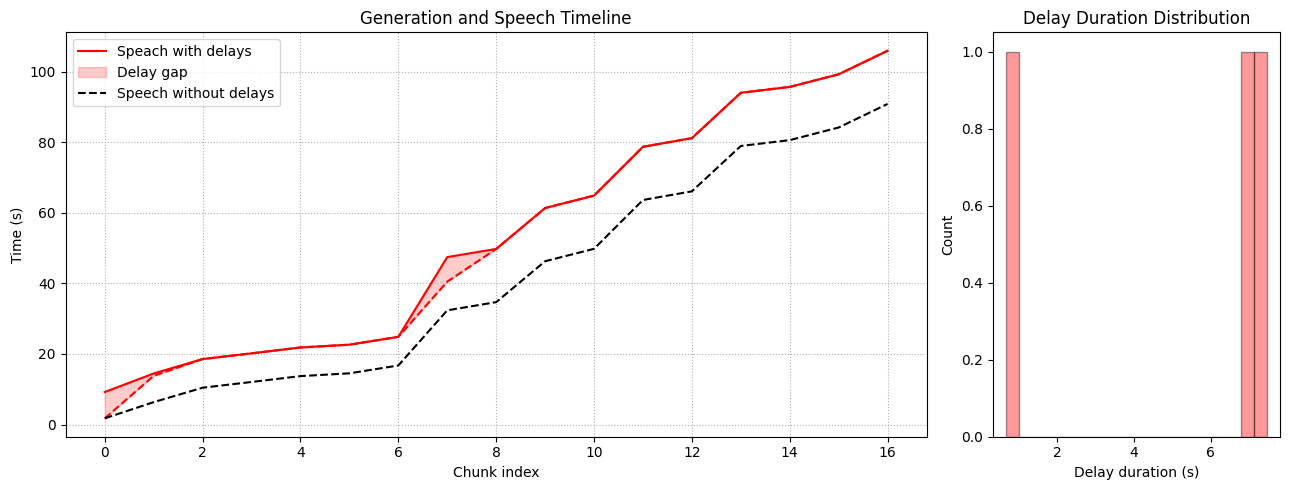

In [8]:
delays = metrics["delays"]

from utils.plotting import plot_one_timeline
plot_one_timeline(chunks["spk_times"], delays)

Real setup


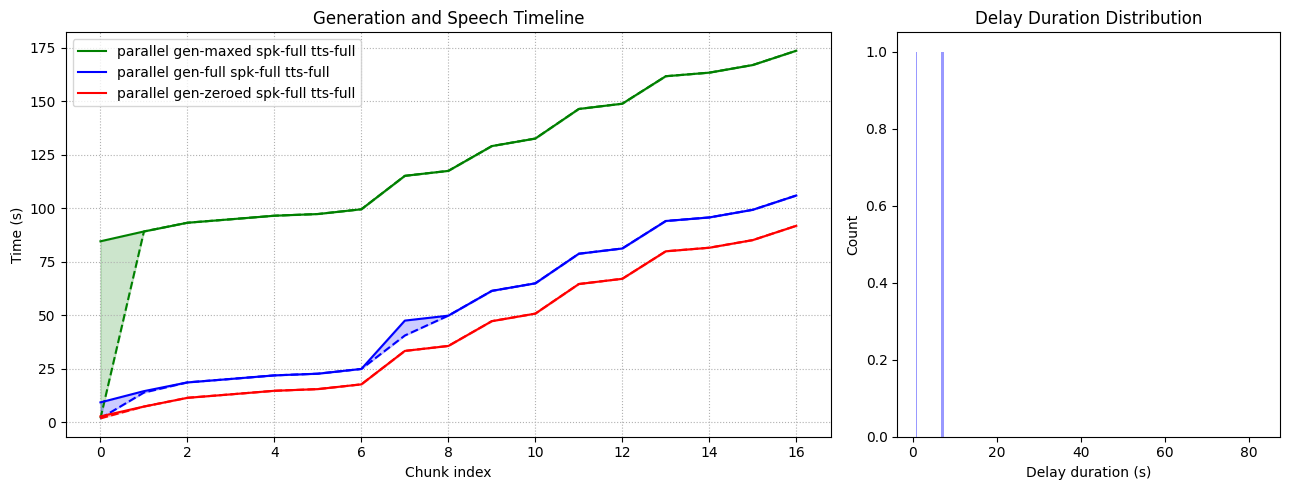

We want to compose audio file as fast as possible


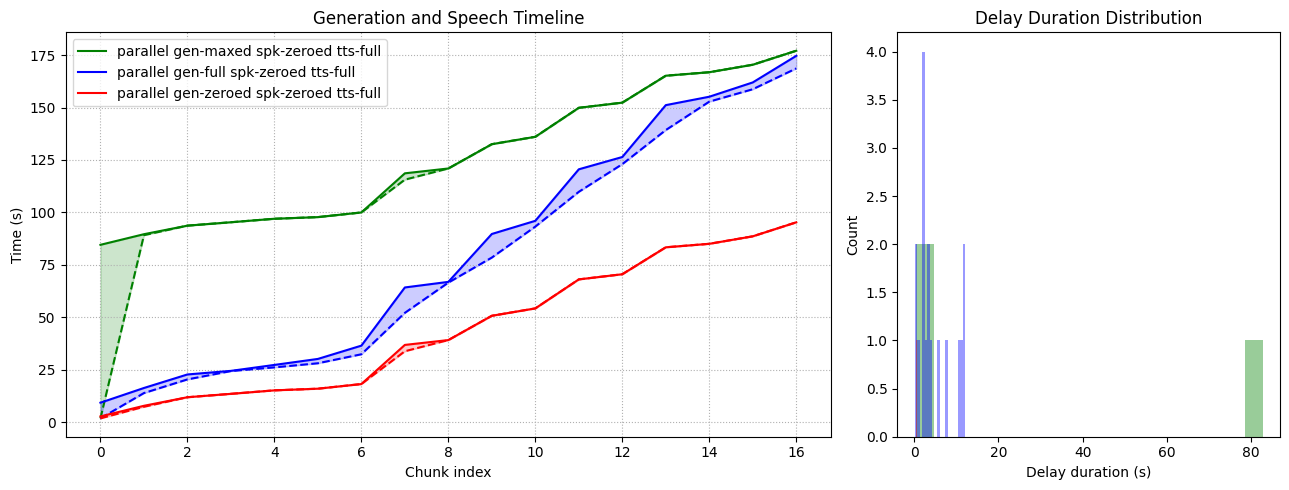

With sequential generation final time does not change from rearranging order of ops


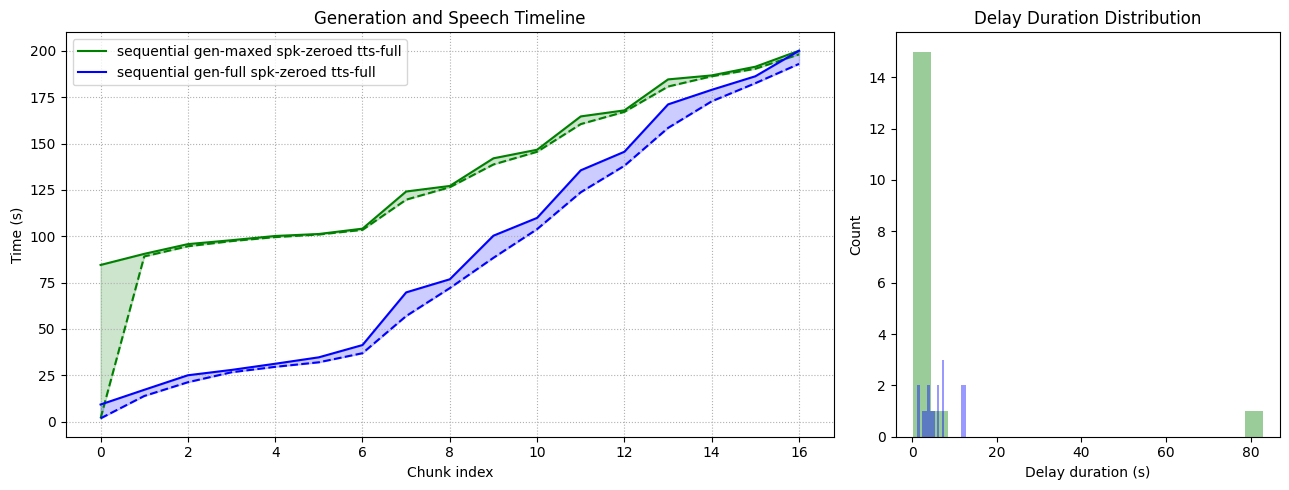

In [10]:
from utils.plotting import plot_timelines

# All possible arguments:
# mode_variants = ["parallel", "sequential"], <-- do we compute llm and tts sequentially or parallel
# gen_variants = ["maxed", "full", "zeroed"], <-- emulates 1) starting tts after finishing llm, 2) our setup, 3) when we have text generated
# spk_variants = ["full", "zeroed"], <-- Use or ignore time for human to listen
# tts_variants = ["full", "zeroed"], <-- Use or ignore time for tts to generate audio

# In my oppinion the most interesting are:

print("Real setup")
plot_timelines(
    evaluator,
    chunks, 
    mode_variants = ["parallel"],
    gen_variants = ["maxed", "full", "zeroed"],
    spk_variants = ["full"],
    tts_variants = ["full"],
)

print("We want to compose audio file as fast as possible") # Cannot use listening time for compute
plot_timelines(
    evaluator,
    chunks, 
    mode_variants = ["parallel"],
    gen_variants = ["maxed", "full", "zeroed"],
    spk_variants = ["zeroed"],
    tts_variants = ["full"],
)

print("With sequential generation final time does not change from rearranging order of ops") # Cannot use listening time for compute
plot_timelines(
    evaluator,
    chunks, 
    mode_variants = ["sequential"],
    gen_variants = ["maxed", "full"],
    spk_variants = ["zeroed"],
    tts_variants = ["full"],
)

In [11]:
# You can substitude both gen_times and (tts and speach) times
# or only (tts and speach) times

# Example: how to call evaluator with the same data with different parameters
metrics = evaluator(
    gen_times = chunks["gen_times"],
    spk_times = np.zeros_like(chunks["spk_times"]),
    tts_times = chunks["tts_times"],
    add_tts_in_parrallel = True,
    )
print(metrics["total_delay"])

# Examples: how to call evaluator with full mock data
metrics = evaluator(
    gen_times = np.zeros_like(chunks["gen_times"]),
    spk_times = np.zeros_like(chunks["spk_times"]),
    tts_times = chunks["tts_times"],
    add_tts_in_parrallel = True,
    )
print(metrics["total_delay"])

metrics = evaluator(
    gen_times = np.ones_like(chunks["gen_times"]) * chunks["gen_times"][-1],
    spk_times = np.zeros_like(chunks["spk_times"]),
    tts_times = chunks["tts_times"],
    add_tts_in_parrallel = False,
    )
print(metrics["total_delay"])

# For full mock evals but with previously obtained data
# You can call same metrics in more human-readable form

# These are the same as two previous
metrics = evaluator(**evaluator.get_kwargs_by_description(chunks, "parallel", "zeroed", "zeroed", "full"))
print(metrics["total_delay"])
metrics = evaluator(**evaluator.get_kwargs_by_description(chunks, "sequential", "maxed", "zeroed", "full"))
print(metrics["total_delay"])

83.81102331797592
4.412801600061357
109.28894966421649
4.412801600061357
109.28894966421649
